#### Competition Link : 
https://www.kaggle.com/competitions/diamond-price-prediciton-2024

#### Team Name : 'ShAI - B'

## Import Libraries

In [1]:
import joblib
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV

from sklearn.metrics import mean_squared_error, mean_absolute_error

import warnings
warnings.filterwarnings("ignore")

## Load Data

In [2]:
# Kaggle
# train_df = pd.read_csv(r"/kaggle/input/diamond-data/train.csv")
# test_df  = pd.read_csv(r"/kaggle/input/diamond-data/test.csv")

# # Jupyter
train_df = pd.read_csv(r"diamond-data/train.csv")
test_df  = pd.read_csv(r"diamond-data/test.csv")

train_df.head(5)

,Id,carat,cut,color,clarity,depth,table,price,x,y,z
0,1,1.06,Ideal,I,SI2,61.8,57.0,4270,6.57,6.60,4.07
1,2,1.51,Premium,G,VVS2,60.9,58.0,15164,7.38,7.42,4.51
2,3,0.32,Ideal,F,VS2,61.3,56.0,828,4.43,4.41,2.71
3,4,0.53,Ideal,G,VS2,61.2,56.0,1577,5.19,5.22,3.19
4,5,0.70,Premium,H,VVS2,61.0,57.0,2596,5.76,5.72,3.50


## Data Preprocessing

In [3]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 43152 entries, 0 to 43151
Data columns (total 11 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   Id       43152 non-null  int64  
 1   carat    43152 non-null  float64
 2   cut      43152 non-null  object 
 3   color    43152 non-null  object 
 4   clarity  43152 non-null  object 
 5   depth    43152 non-null  float64
 6   table    43152 non-null  float64
 7   price    43152 non-null  int64  
 8   x        43152 non-null  float64
 9   y        43152 non-null  float64
 10  z        43152 non-null  float64
dtypes: float64(6), int64(2), object(3)
memory usage: 3.6+ MB


In [4]:
train_df.describe()

,Id,carat,depth,table,price,x,y,z
count,43152.000000,43152.000000,43152.000000,43152.000000,43152.000000,43152.000000,43152.000000,43152.000000
mean,21576.500000,0.797855,61.747177,57.458347,3929.491912,5.731568,5.735018,3.538568
std,12457.053745,0.473594,1.435454,2.233904,3985.527795,1.121279,1.148809,0.708238
min,1.000000,0.200000,43.000000,43.000000,326.000000,0.000000,0.000000,0.000000
25%,10788.750000,0.400000,61.000000,56.000000,947.750000,4.710000,4.720000,2.910000
50%,21576.500000,0.700000,61.800000,57.000000,2401.000000,5.700000,5.710000,3.530000
75%,32364.250000,1.040000,62.500000,59.000000,5312.000000,6.540000,6.540000,4.040000
max,43152.000000,5.010000,79.000000,95.000000,18823.000000,10.740000,58.900000,31.800000


In [5]:
train_df.describe(include='O')

,cut,color,clarity
count,43152,43152,43152
unique,5,7,8
top,Ideal,G,SI1
freq,17203,9060,10428


### Cleaning

In [6]:
train_df.isna().sum()

Id         0
carat      0
cut        0
color      0
clarity    0
depth      0
table      0
price      0
x          0
y          0
z          0
dtype: int64

In [7]:
train_df.duplicated().sum()

0

### Handling

In [8]:
train_df.sample(5)

,Id,carat,cut,color,clarity,depth,table,price,x,y,z
37078,37079,0.90,Premium,H,SI1,62.0,62.0,3679,6.13,6.03,3.77
25723,25724,0.60,Premium,F,SI2,58.9,59.0,1378,5.55,5.52,3.26
13718,13719,0.90,Premium,H,VS1,61.5,59.0,4064,6.19,6.13,3.79
25743,25744,1.12,Ideal,I,SI2,62.4,57.0,3688,6.69,6.62,4.15
34278,34279,1.06,Very Good,H,SI2,62.8,57.0,4372,6.49,6.57,4.10


In [9]:
len(train_df[(train_df['z'] == 0) | (train_df['y'] == 0) | (train_df['x'] == 0)])

17

In [10]:
# x, y, z Will be replaced with vol, af vol == 0, then handle it with the mean of carat weight in specific range (c-0.1, c+0.1)

def handle_test_xyz(col, df="test_df"):
    sub_test_df = df[df[col] == 0]
    for ID in sub_test_df["Id"]:
        carat_ = float(sub_test_df[sub_test_df["Id"] == ID]["carat"])
        
        carat_min = carat_ - 0.1
        carat_max = carat_ + 0.1
        
        sub_train_df = train_df[(train_df["carat"] >= carat_min) & (train_df["carat"] <= carat_max) ]
        
        df.loc[df["Id"] == ID, col] = sub_train_df[col].mean()
        sub_test_df.loc[sub_test_df["Id"] == ID, col] = sub_train_df[col].mean()
        
        
handle_test_xyz("x", train_df)
handle_test_xyz("y", train_df)
handle_test_xyz("z", train_df)

In [11]:
print("Total number of (X & Y & Z) Zeros = " ,len(test_df[(test_df['z'] == 0) | (test_df['y'] == 0) | (test_df['x'] == 0)]))

handle_test_xyz("x", test_df)
handle_test_xyz("y", test_df)
handle_test_xyz("z", test_df)

Total number of (X & Y & Z) Zeros =  3


##### 

In [12]:
train_df = train_df.drop(["Id"], axis=1)

test_IDs = test_df["Id"]
test_df  = test_df.drop(["Id"], axis=1)

### 

In [13]:
train_df_copy = train_df.copy()

### 

In [79]:
print(train_df["cut"].unique())
print(train_df["color"].unique())
print(train_df["clarity"].unique())

['Fair', 'Good', 'Very Good', 'Premium', 'Ideal']
['J', 'I', 'H', 'G', 'F', 'E', 'D']
['I1', 'SI2', 'SI1', 'VS2', 'VS1', 'VVS2', 'VVS1', 'IF']


In [17]:
cut_column_unique_ordered = ['Fair', 'Good', 'Very Good', 'Premium', 'Ideal']
color_column_unique_ordered = ["J", "I", "H", "G", "F", "E", "D"]
clarity_column_unique_ordered = ["I1", "SI2", "SI1", "VS2", "VS1", "VVS2", "VVS1", "IF"]

### 

In [19]:
train_df["cut"].replace({"Fair":0, "Good":1, "Very Good":2, "Premium":3, "Ideal":4}, inplace=True)
test_df ["cut"].replace({"Fair":0, "Good":1, "Very Good":2, "Premium":3, "Ideal":4}, inplace=True)

train_df["color"].replace({"J":0, "I":1, "H":2, "G":3, "F":4, "E":5, "D":6}, inplace=True)
test_df ["color"].replace({"J":0, "I":1, "H":2, "G":3, "F":4, "E":5, "D":6}, inplace=True)

train_df["clarity"].replace({"I1":0, "SI2":1, "SI1":2, "VS2":3, "VS1":4, "VVS2":5, "VVS1":6, "IF":7}, inplace=True)
test_df ["clarity"].replace({"I1":0, "SI2":1, "SI1":2, "VS2":3, "VS1":4, "VVS2":5, "VVS1":6, "IF":7}, inplace=True)

#### 

In [24]:
train_df["depth"] = 2 * train_df["z"] / (train_df["x"] + train_df["y"]) * 100
test_df["depth"]  = 2 * test_df["z"]  / (test_df["x"]  + test_df["y"]) * 100

## Data Visualization

<AxesSubplot:>

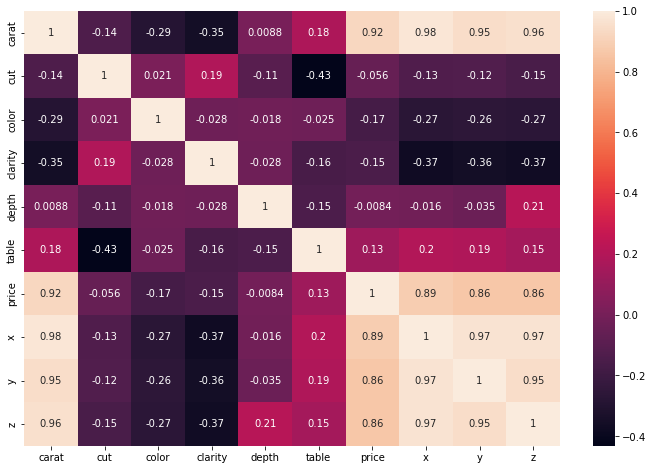

In [25]:
plt.subplots(figsize=(12, 8))
sns.heatmap(train_df.corr(), annot=True)

array([[<AxesSubplot:title={'center':'carat'}>,
        <AxesSubplot:title={'center':'depth'}>,
        <AxesSubplot:title={'center':'table'}>],
       [<AxesSubplot:title={'center':'x'}>,
        <AxesSubplot:title={'center':'y'}>,
        <AxesSubplot:title={'center':'z'}>],
       [<AxesSubplot:title={'center':'price'}>, <AxesSubplot:>,
        <AxesSubplot:>]], dtype=object)

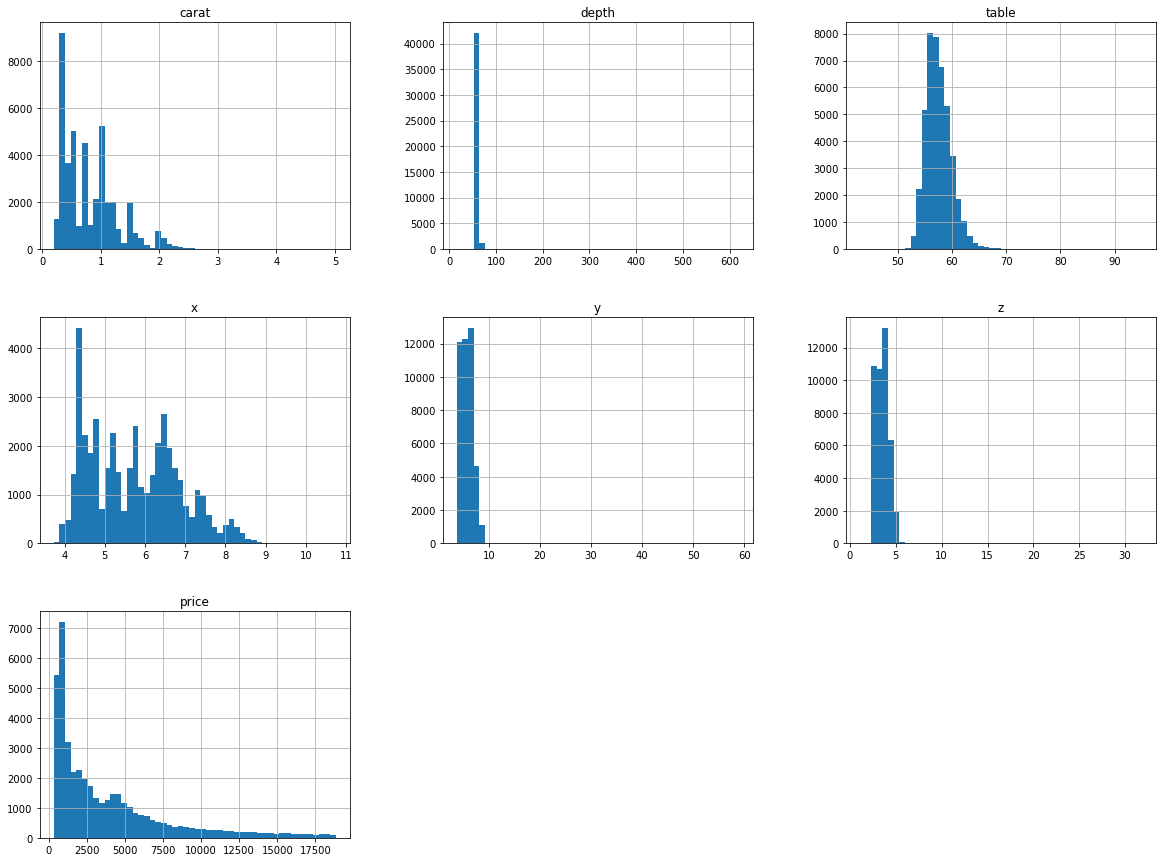

In [26]:
train_df.loc[:, ["carat", "depth", "table", "x", "y", "z", "price"]].hist(figsize=(20, 15), bins=50)

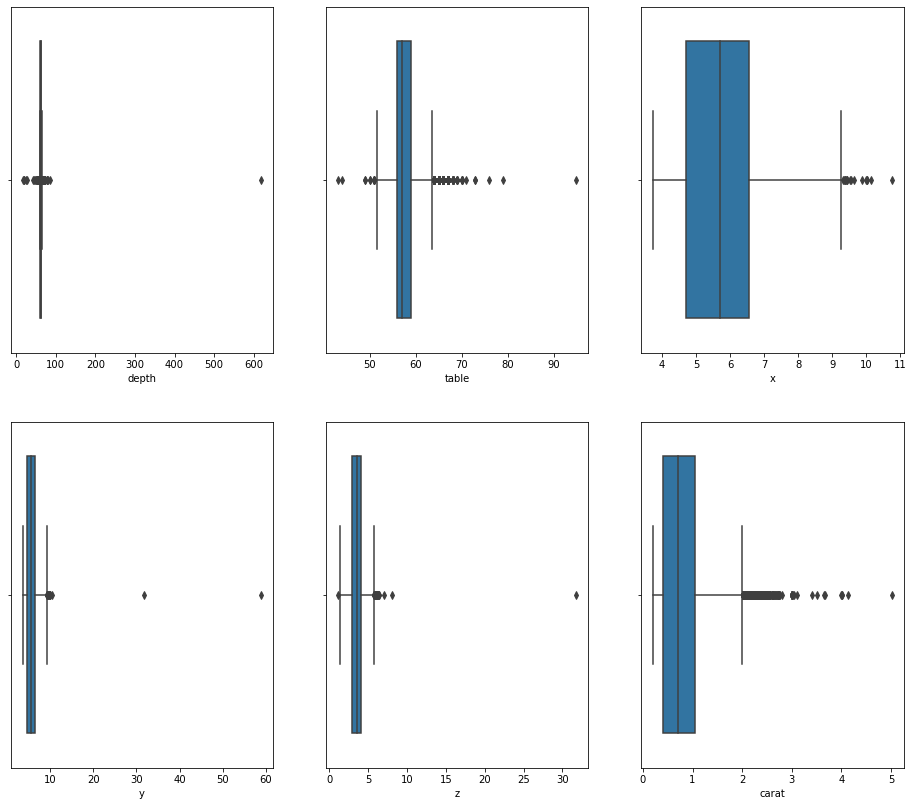

In [27]:
fig, axes = plt.subplots(2, 3, figsize=(16, 14))
for i, cols in enumerate(["carat","depth", "table", "x", "y", "z"], 1):
    sns.boxplot(data=train_df, x=cols)
    plt.subplot(2, 3, i)

plt.show()

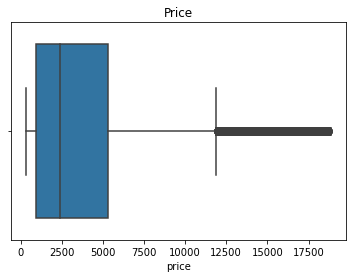

In [28]:
sns.boxplot(data=train_df, x="price")
plt.title("Price")
plt.show()

In [29]:
def get_outliers(col, train_df = train_df):
    Q1 = train_df[col].quantile(0.25)
    Q3 = train_df[col].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    iqr_outliers = train_df[(train_df[col] < lower_bound) | (train_df[col] > upper_bound)]
    
    return lower_bound, upper_bound,len(iqr_outliers)


for col in train_df.columns[:7]:
    lower_bound, upper_bound, outliers = get_outliers(col)
    print(f"Number of outliers detected based on IQR method ({str(col).center(8)}) : ", str(outliers).rjust(4), f"Lower = {str(round(lower_bound, 3)).rjust(10)}", f"Upper = {str(round(upper_bound, 2)).rjust(10)}")        

Number of outliers detected based on IQR method ( carat  ) :  1504 Lower =      -0.56 Upper =        2.0
Number of outliers detected based on IQR method (  cut   ) :     0 Lower =       -1.0 Upper =        7.0
Number of outliers detected based on IQR method ( color  ) :     0 Lower =       -2.5 Upper =        9.5
Number of outliers detected based on IQR method (clarity ) :     0 Lower =       -1.0 Upper =        7.0
Number of outliers detected based on IQR method ( depth  ) :  2182 Lower =     58.813 Upper =      64.76
Number of outliers detected based on IQR method ( table  ) :   472 Lower =       51.5 Upper =       63.5
Number of outliers detected based on IQR method ( price  ) :  2844 Lower =  -5598.625 Upper =   11858.38


### Outliers Handling

<AxesSubplot:xlabel='carat', ylabel='price'>

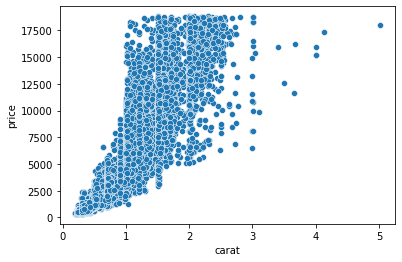

In [30]:
sns.scatterplot(x=train_df["carat"], y=train_df["price"])

In [31]:
print(f"Carat Outliers : {len(train_df[train_df['carat'] > 3])}") # Visualization
train_df = train_df[train_df["carat"] <= 3 ] # 3

Carat Outliers : 21


#### 

<AxesSubplot:xlabel='depth', ylabel='price'>

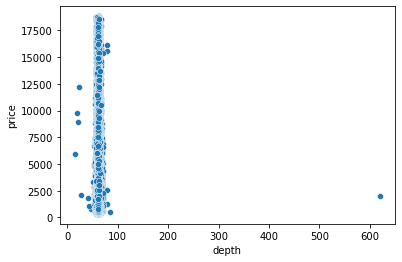

In [32]:
sns.scatterplot(x=train_df["depth"], y=train_df["price"])

In [33]:
print(f"Depth Outliers : {len(train_df[(train_df['depth'] < 50) | (train_df['depth'] > 75)])}") # Depth Outliers : 14
train_df = train_df[(train_df["depth"] >= 50) & (train_df["depth"] <= 75)]

Depth Outliers : 14


##### 

<AxesSubplot:xlabel='table', ylabel='price'>

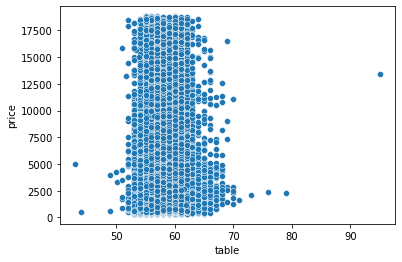

In [34]:
sns.scatterplot(x=train_df["table"], y=train_df["price"])

In [35]:
print(f"Table Outliers : {len(train_df[(train_df['table'] < 50) | (train_df['table'] > 70)])}") # Table Outliers : 9
train_df = train_df[(train_df["table"] >= 50) & (train_df["table"] <= 70)]

Table Outliers : 9


### 

<AxesSubplot:xlabel='x', ylabel='price'>

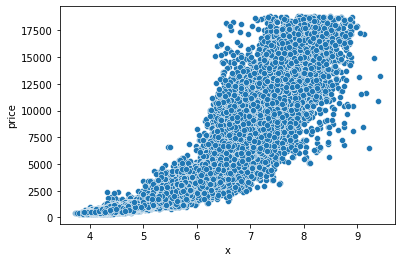

In [36]:
sns.scatterplot(data=train_df, x="x", y="price")

In [37]:
print(f"X Outliers : {len(train_df[train_df['x'] > 9])}") # X Outliers : 
train_df = train_df[train_df["x"] <= 9]

X Outliers : 10


### 

<AxesSubplot:xlabel='y', ylabel='price'>

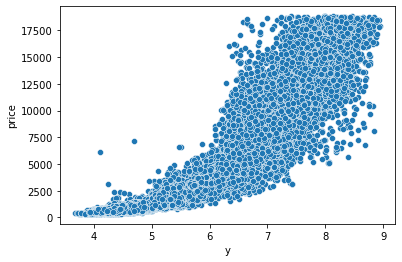

In [38]:
sns.scatterplot(data=train_df, x="y", y="price")

In [39]:
print(f"Y Outliers : {len(train_df[train_df['y'] > 9])}") # Y Outliers : 0
train_df = train_df[train_df["y"] <= 9]

Y Outliers : 0


### 

<AxesSubplot:xlabel='z', ylabel='price'>

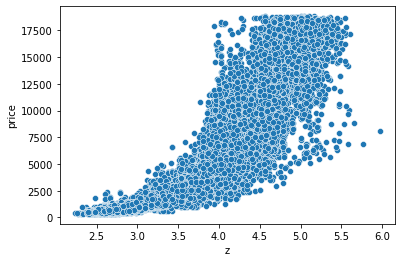

In [40]:
sns.scatterplot(data=train_df, x="z", y="price")

In [41]:
print(f"Z Outliers : {len(train_df[(train_df['z'] < 2) | (train_df['z'] > 7)])}") # Z Outliers : 0
train_df = train_df[(train_df["z"] >= 2) & (train_df["z"] <= 7)]

Z Outliers : 0


#### 

<AxesSubplot:>

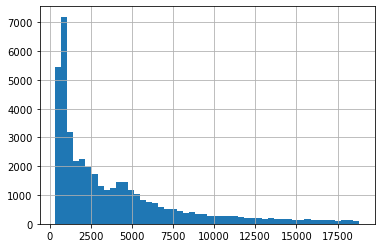

In [42]:
train_df["price"].hist(bins=50)

In [43]:
# train_df = train_df[train_df["price"] <= 11857] # Visulization

### 

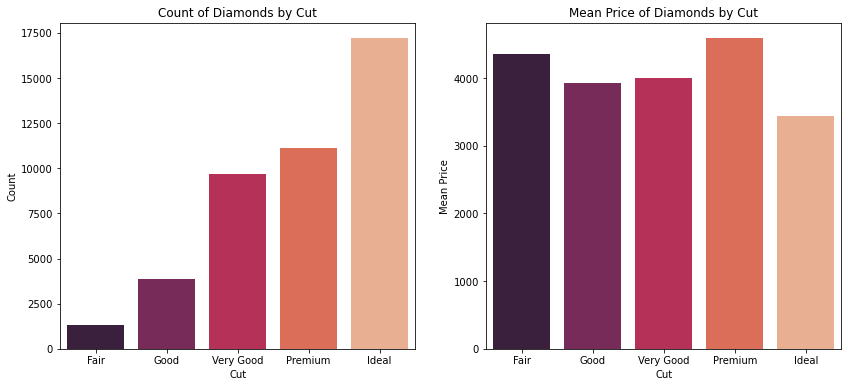

In [44]:
mean_price_by_cut = train_df_copy.groupby("cut")["price"].mean().reindex(cut_column_unique_ordered)

# Create subplots
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

sns.countplot(data=train_df_copy, x="cut", order=cut_column_unique_ordered, ax=axes[0], palette='rocket')
axes[0].set_title("Count of Diamonds by Cut")
axes[0].set_xlabel("Cut")
axes[0].set_ylabel("Count")

sns.barplot(x=mean_price_by_cut.index, y=mean_price_by_cut.values, ax=axes[1], palette='rocket')
axes[1].set_title("Mean Price of Diamonds by Cut")
axes[1].set_xlabel("Cut")
axes[1].set_ylabel("Mean Price")

# # Adjust layout
# plt.tight_layout()

# Show plot
plt.show()

### 

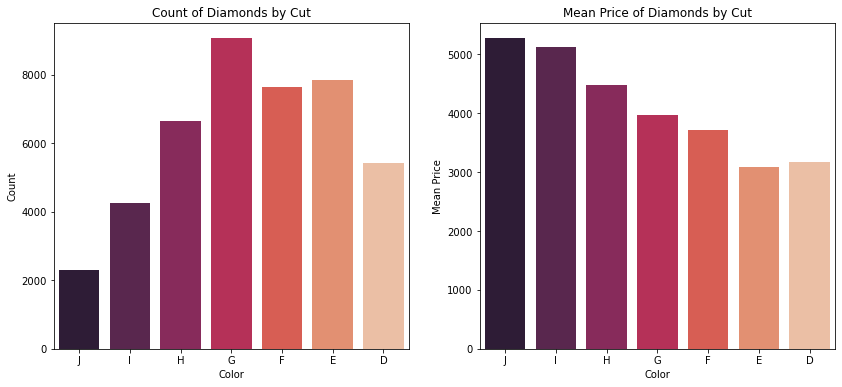

In [45]:
mean_price_by_color = train_df_copy.groupby("color")["price"].mean().reindex(color_column_unique_ordered)

# Create subplots
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

sns.countplot(data=train_df_copy, x="color", order=color_column_unique_ordered, ax=axes[0], palette='rocket')
axes[0].set_title("Count of Diamonds by Cut")
axes[0].set_xlabel("Color")
axes[0].set_ylabel("Count")

sns.barplot(x=mean_price_by_color.index, y=mean_price_by_color.values, ax=axes[1], palette='rocket')
axes[1].set_title("Mean Price of Diamonds by Cut")
axes[1].set_xlabel("Color")
axes[1].set_ylabel("Mean Price")

# # Adjust layout
# plt.tight_layout()

# Show plot
plt.show()

### 

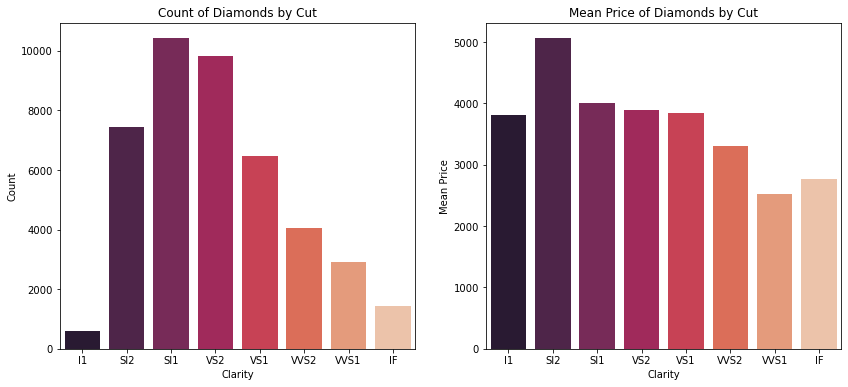

In [46]:
mean_price_by_clarity = train_df_copy.groupby("clarity")["price"].mean().reindex(clarity_column_unique_ordered)

# Create subplots
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

sns.countplot(data=train_df_copy, x="clarity", order=clarity_column_unique_ordered, ax=axes[0], palette='rocket')
axes[0].set_title("Count of Diamonds by Cut")
axes[0].set_xlabel("Clarity")
axes[0].set_ylabel("Count")

sns.barplot(x=mean_price_by_clarity.index, y=mean_price_by_clarity.values, ax=axes[1], palette='rocket')
axes[1].set_title("Mean Price of Diamonds by Cut")
axes[1].set_xlabel("Clarity")
axes[1].set_ylabel("Mean Price")

# # Adjust layout
# plt.tight_layout()

# Show plot
plt.show()

### 

## Feature Engineering 

In [47]:
train_df_copy["vol"] = train_df_copy["x"] * train_df_copy["y"] * train_df_copy["z"] # For Categorical Visualization
# train_df_copy.drop(["x", "y", "z"], axis=1, inplace=True)

train_df["vol"] = train_df["x"] * train_df["y"] * train_df["z"]                     # For Training
train_df.drop(["x", "y", "z"], axis=1, inplace=True)

test_df["vol"] = test_df["x"] * test_df["y"] * test_df["z"]                         # For Testing
test_df.drop(["x", "y", "z"], axis=1, inplace=True)

In [48]:
train_df.corr()["price"].sort_values(ascending=False)

price      1.000000
vol        0.925684
carat      0.923804
table      0.128216
depth     -0.012523
cut       -0.055404
clarity   -0.145010
color     -0.170249
Name: price, dtype: float64

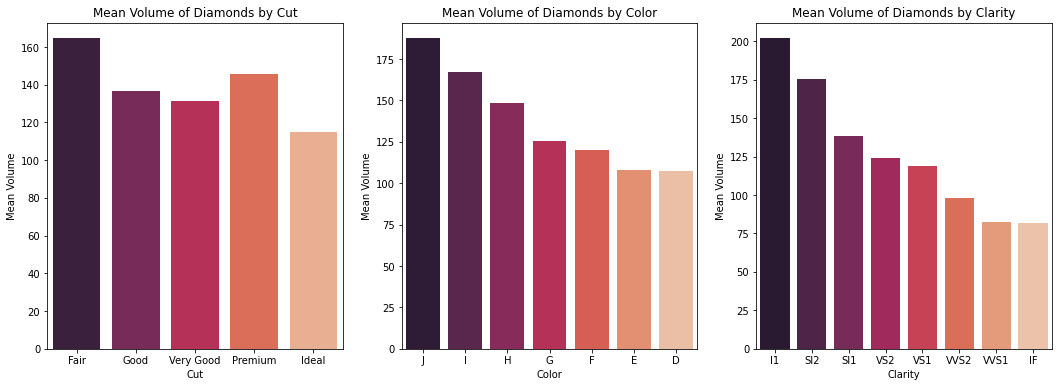

In [49]:
mean_vol_by_cut     = train_df_copy.groupby("cut")["vol"].mean().reindex(cut_column_unique_ordered)
mean_vol_by_color   = train_df_copy.groupby("color")["vol"].mean().reindex(color_column_unique_ordered)
mean_vol_by_clarity = train_df_copy.groupby("clarity")["vol"].mean().reindex(clarity_column_unique_ordered)

fig, axes = plt.subplots(1, 3, figsize=(18, 6))

# Mean volume by cut
sns.barplot(x=mean_vol_by_cut.index, y=mean_vol_by_cut.values, palette='rocket', ax=axes[0])
axes[0].set_title("Mean Volume of Diamonds by Cut")
axes[0].set_xlabel("Cut")
axes[0].set_ylabel("Mean Volume")

# Mean volume by color
sns.barplot(x=mean_vol_by_color.index, y=mean_vol_by_color.values, palette='rocket', ax=axes[1])
axes[1].set_title("Mean Volume of Diamonds by Color")
axes[1].set_xlabel("Color")
axes[1].set_ylabel("Mean Volume")

# Mean volume by clarity
sns.barplot(x=mean_vol_by_clarity.index, y=mean_vol_by_clarity.values, palette='rocket', ax=axes[2])
axes[2].set_title("Mean Volume of Diamonds by Clarity")
axes[2].set_xlabel("Clarity")
axes[2].set_ylabel("Mean Volume")

## Adjust layout
# plt.tight_layout()

# Show plot
plt.show()

In [50]:
train_df.sample(3)

,carat,cut,color,clarity,depth,table,price,vol
1058,0.32,4,4,7,61.192351,57.0,958,53.741760
42371,1.02,3,2,3,60.443764,59.0,5008,168.688700
40371,0.73,4,4,2,61.485320,55.0,2951,119.344372


In [51]:
test_df.sample(3)

,carat,cut,color,clarity,depth,table,vol
2222,0.34,4,3,6,61.931188,54.0,56.622492
4944,1.10,2,4,6,59.807550,54.0,184.344392
9442,1.08,4,3,2,61.422088,56.0,177.389520


### 

## Scaling & Spliting 

### Scaling

In [52]:
y = train_df["price"]
X = train_df.drop(["price"], axis=1)

In [53]:
scaler = StandardScaler()
scaler.fit(X)

scaled_X = scaler.fit_transform(X)
submission_data = scaler.fit_transform(test_df)

In [54]:
train_df.head()

,carat,cut,color,clarity,depth,table,price,vol
0,1.06,4,1,1,61.807137,57.0,4270,176.483340
1,1.51,3,3,5,60.945946,58.0,15164,246.965796
2,0.32,4,4,3,61.312217,56.0,828,52.943373
3,0.53,4,3,3,61.287224,56.0,1577,86.422842
4,0.70,3,2,5,60.975610,57.0,2596,115.315200


### Spliting

In [55]:
X_train, X_test, y_train, y_test = train_test_split(scaled_X, y, random_state=42, test_size = 0.2)

In [56]:
len(X_train)

42236

### 

## Model Selection & Training

#### 1-  Linear Regression

In [57]:
from sklearn.linear_model import LinearRegression

linearReg_model = LinearRegression()
linearReg_model.fit(X_train, y_train)

linearReg_y_pred = linearReg_model.predict(X_test)
linearReg_RMSE = np.sqrt(mean_squared_error(y_test, linearReg_y_pred))
linearReg_MAE = mean_absolute_error(y_test, linearReg_y_pred)


print("Linear Regression RMSE :", linearReg_RMSE)
print("Linear Regression MAE  :", linearReg_MAE, "\n")

for index, (real_value, predicted_value) in zip(range(10), zip(y_test, linearReg_y_pred)):
    print(f"Real value is {str(round(real_value)).rjust(5)} | The predicted value is {str(round(predicted_value)).rjust(5)}")

Linear Regression RMSE : 1223.9802099892302
Linear Regression MAE  : 859.7176167047971 

Real value is  3390 | The predicted value is  4335
Real value is  3140 | The predicted value is  3433
Real value is  2639 | The predicted value is  3784
Real value is   658 | The predicted value is   193
Real value is  1125 | The predicted value is  1186
Real value is  1943 | The predicted value is  2426
Real value is   449 | The predicted value is  -969
Real value is   971 | The predicted value is  2054
Real value is   765 | The predicted value is  -145
Real value is 14476 | The predicted value is 14071


#### 2- Gradient Boosting

In [58]:
from sklearn.ensemble import GradientBoostingRegressor

gradientBoosting_model = GradientBoostingRegressor(random_state=42)
gradientBoosting_model.fit(X_train, y_train)

gradientBoosting_y_pred = gradientBoosting_model.predict(X_test)
gradientBoosting_RMSE = np.sqrt(mean_squared_error(y_test, gradientBoosting_y_pred))
gradientBoosting_MAE = mean_absolute_error(y_test, gradientBoosting_y_pred)

print("Gradient Boosting RMSE:", gradientBoosting_RMSE)
print("Gradient Boosting MAE  :", gradientBoosting_MAE, "\n")

for index, (real_value, predicted_value) in zip(range(10), zip(y_test, gradientBoosting_y_pred)):
    print(f"Real value is {str(round(real_value)).rjust(5)} | The predicted value is {str(round(predicted_value)).rjust(5)}")

Gradient Boosting RMSE: 624.7616973831518
Gradient Boosting MAE  : 338.49529262139635 

Real value is  3390 | The predicted value is  3304
Real value is  3140 | The predicted value is  2822
Real value is  2639 | The predicted value is  3210
Real value is   658 | The predicted value is   755
Real value is  1125 | The predicted value is   950
Real value is  1943 | The predicted value is  1908
Real value is   449 | The predicted value is   452
Real value is   971 | The predicted value is  1210
Real value is   765 | The predicted value is   777
Real value is 14476 | The predicted value is 16082


#### 3-  Decision Tree

In [59]:
from sklearn.tree import DecisionTreeRegressor

decisionTree_model = DecisionTreeRegressor()
decisionTree_model.fit(X_train, y_train)

decisionTree_y_pred = decisionTree_model.predict(X_test)
decisionTree_RMSE = np.sqrt(mean_squared_error(y_test, decisionTree_y_pred))
decisionTree_MAE = mean_absolute_error(y_test, decisionTree_y_pred)

print("Decision Tree RMSE :", decisionTree_RMSE)
print("Decision Tree MAE  :", decisionTree_MAE, "\n")

for index, (real_value, predicted_value) in zip(range(10), zip(y_test, decisionTree_y_pred)):    
    print(f"Real value is {str(round(real_value)).rjust(5)} | The predicted value is {str(round(predicted_value)).rjust(5)}")

Decision Tree RMSE : 717.1974514666841
Decision Tree MAE  : 346.60054137664343 

Real value is  3390 | The predicted value is  3780
Real value is  3140 | The predicted value is  2606
Real value is  2639 | The predicted value is  3084
Real value is   658 | The predicted value is   658
Real value is  1125 | The predicted value is   877
Real value is  1943 | The predicted value is  1837
Real value is   449 | The predicted value is   576
Real value is   971 | The predicted value is  1162
Real value is   765 | The predicted value is   661
Real value is 14476 | The predicted value is 18795


#### 4-  Random Forest

In [60]:
from sklearn.ensemble import RandomForestRegressor

randomForest_model = RandomForestRegressor(n_estimators=200, random_state=42)
randomForest_model.fit(X_train, y_train)

randomForest_y_pred = randomForest_model.predict(X_test)
randomForest_RMSE = np.sqrt(mean_squared_error(y_test, randomForest_y_pred))
randomForest_MAE  = mean_absolute_error(y_test, randomForest_y_pred)

print("Random Forest RMSE :", randomForest_RMSE)
print("Random Forest MAE  :", randomForest_MAE)

for index, (real_value, predicted_value) in zip(range(1, 20), zip(y_test, randomForest_y_pred)):        
    print(f"Real value is {str(round(real_value)).rjust(5)} | The predicted value is {str(round(predicted_value)).rjust(5)}")

Random Forest RMSE : 518.8744073629715
Random Forest MAE  : 262.29325709636134
Real value is  3390 | The predicted value is  3362
Real value is  3140 | The predicted value is  2818
Real value is  2639 | The predicted value is  3297
Real value is   658 | The predicted value is   716
Real value is  1125 | The predicted value is   898
Real value is  1943 | The predicted value is  1890
Real value is   449 | The predicted value is   540
Real value is   971 | The predicted value is  1080
Real value is   765 | The predicted value is   667
Real value is 14476 | The predicted value is 16464
Real value is  2496 | The predicted value is  2516
Real value is  6023 | The predicted value is  6267
Real value is   600 | The predicted value is   653
Real value is 16171 | The predicted value is 17368
Real value is   475 | The predicted value is   517
Real value is  5292 | The predicted value is  4725
Real value is  2772 | The predicted value is  3058
Real value is  5599 | The predicted value is  5843
Rea

### 

## Model Evaluation

In [61]:
randomForest_model2 = RandomForestRegressor()
forest_scores = cross_val_score(randomForest_model2, X_train, y_train, scoring = "neg_mean_squared_error", cv = 5)
forest_rmse_scores = np.sqrt(np.abs(forest_scores))

In [62]:
for score in forest_rmse_scores:
    print(round(score, 3))

537.372
559.6
545.589
545.232
544.803


## Model Fine-Tune 

In [63]:
param_grid = {
    'n_estimators': [50, 100],
    'max_features': [2, 3],
    'max_depth'   : [None],
    'min_samples_split' : [2, 5],
    'min_samples_leaf'  : [1, 2],
}


randomForest_model3 = RandomForestRegressor(random_state = 42)

grid_search = GridSearchCV(randomForest_model3, param_grid, cv = 5, scoring = 'neg_mean_squared_error', return_train_score = True)
grid_search.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=RandomForestRegressor(random_state=42),
             param_grid={'max_depth': [None], 'max_features': [2, 3],
                         'min_samples_leaf': [1, 2],
                         'min_samples_split': [2, 5],
                         'n_estimators': [50, 100]},
             return_train_score=True, scoring='neg_mean_squared_error')

In [64]:
cvres = grid_search.cv_results_

for mean_score, params in zip(cvres["mean_test_score"],cvres["params"]):
    print(round(np.sqrt(np.abs(mean_score)), 2), params)

559.13 {'max_depth': None, 'max_features': 2, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 50}
555.52 {'max_depth': None, 'max_features': 2, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100}
559.31 {'max_depth': None, 'max_features': 2, 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 50}
557.99 {'max_depth': None, 'max_features': 2, 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 100}
565.79 {'max_depth': None, 'max_features': 2, 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 50}
563.62 {'max_depth': None, 'max_features': 2, 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 100}
566.91 {'max_depth': None, 'max_features': 2, 'min_samples_leaf': 2, 'min_samples_split': 5, 'n_estimators': 50}
565.55 {'max_depth': None, 'max_features': 2, 'min_samples_leaf': 2, 'min_samples_split': 5, 'n_estimators': 100}
540.74 {'max_depth': None, 'max_features': 3, 'min_samples_leaf': 1, 'min_samples_split': 2,

In [65]:
feature_importances = grid_search.best_estimator_.feature_importances_
feature_importances

array([0.34873449, 0.00377354, 0.03094633, 0.05730351, 0.00665774,
       0.00521374, 0.54737064])

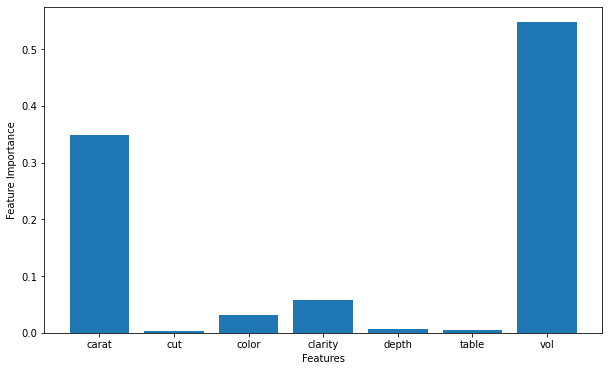

In [66]:
# Plotting feature importances
plt.figure(figsize=(10, 6))
plt.bar(X.columns, feature_importances)
plt.xlabel('Features')
plt.ylabel('Feature Importance')
plt.show()

In [70]:
best_model = grid_search.best_estimator_
joblib.dump(best_model, 'RandomForest_TheBest_.pkl')

['RandomForest_TheBest_.pkl']

In [73]:
best_predictions = best_model.predict(X_test)
mse = mean_squared_error(y_test, best_predictions)
rmse = np.sqrt(np.abs(mse))
rmse

530.5410374065833

## Final Prediction

In [74]:
best_predictions2 = best_model.predict(submission_data)

In [75]:
for index, pred in zip(range(1, 20), best_predictions2):
    print(f"{str(index).rjust(2)} - ", str(round(pred, 1)).rjust(7))

 1 -    820.3
 2 -   2951.6
 3 -    886.6
 4 -   2793.7
 5 -   1094.0
 6 -  10738.4
 7 -   5878.4
 8 -   4537.0
 9 -   2076.7
10 -    749.5
11 -   1759.4
12 -   1520.6
13 -   4330.9
14 -   5055.8
15 -   1149.1
16 -   2642.9
17 -   2392.2
18 -  12146.6
19 -   4534.5


## Submission Dataset

In [76]:
# Dataset contains 2 columns | 1st one is the ID, 2nd one is the prediction

data_for_sub = pd.DataFrame({"ID":test_IDs, "price":best_predictions2})
data_for_sub.to_csv("Submission RF.csv", index=False)

In [78]:
data_for_sub.head(10)

,ID,price
0,1,820.288075
1,2,2951.591718
2,3,886.639531
3,4,2793.652299
4,5,1094.002108
5,6,10738.383532
6,7,5878.404864
7,8,4537.032964
8,9,2076.712972
9,10,749.531571
